<a href="https://colab.research.google.com/github/Sanjeev-kumaar008/YT_Shorts_Classification_predictions/blob/main/yt_shorts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [80]:
!pip install imbalanced-learn


In [81]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
import requests
import io
from imblearn.over_sampling import SMOTE
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, roc_auc_score)
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline


In [82]:
import_data = pd.read_csv('/content/youtube_shorts_performance_dataset.csv')
import_data.head()

,video_id,title,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,category
0,vid_1000,Short Video #0,43,9,198775,21933,3228,400,8,Tech
1,vid_1001,Short Video #1,56,2,290336,20063,3719,1942,16,Comedy
2,vid_1002,Short Video #2,33,6,264206,37032,3228,1817,7,Food
3,vid_1003,Short Video #3,19,9,85076,27269,2371,980,1,Lifestyle
4,vid_1004,Short Video #4,47,8,90780,8041,2891,1109,23,Tech


In [83]:
import_data.isnull().sum()

,0
video_id,0
title,0
duration_sec,0
hashtags_count,0
views,0
likes,0
comments,0
shares,0
upload_hour,0
category,0


In [84]:
for i in import_data.columns:
  print(import_data[i].unique())

['vid_1000' 'vid_1001' 'vid_1002' 'vid_1003' 'vid_1004' 'vid_1005'
 'vid_1006' 'vid_1007' 'vid_1008' 'vid_1009' 'vid_1010' 'vid_1011'
 'vid_1012' 'vid_1013' 'vid_1014' 'vid_1015' 'vid_1016' 'vid_1017'
 'vid_1018' 'vid_1019' 'vid_1020' 'vid_1021' 'vid_1022' 'vid_1023'
 'vid_1024' 'vid_1025' 'vid_1026' 'vid_1027' 'vid_1028' 'vid_1029'
 'vid_1030' 'vid_1031' 'vid_1032' 'vid_1033' 'vid_1034' 'vid_1035'
 'vid_1036' 'vid_1037' 'vid_1038' 'vid_1039' 'vid_1040' 'vid_1041'
 'vid_1042' 'vid_1043' 'vid_1044' 'vid_1045' 'vid_1046' 'vid_1047'
 'vid_1048' 'vid_1049' 'vid_1050' 'vid_1051' 'vid_1052' 'vid_1053'
 'vid_1054' 'vid_1055' 'vid_1056' 'vid_1057' 'vid_1058' 'vid_1059'
 'vid_1060' 'vid_1061' 'vid_1062' 'vid_1063' 'vid_1064' 'vid_1065'
 'vid_1066' 'vid_1067' 'vid_1068' 'vid_1069' 'vid_1070' 'vid_1071'
 'vid_1072' 'vid_1073' 'vid_1074' 'vid_1075' 'vid_1076' 'vid_1077'
 'vid_1078' 'vid_1079' 'vid_1080' 'vid_1081' 'vid_1082' 'vid_1083'
 'vid_1084' 'vid_1085' 'vid_1086' 'vid_1087' 'vid_1088' 'vid_1

In [85]:

def apply_f(x , q1 , q2):
    if x >= q2:
        return 'high'
    elif x >= q1 and x < q2:
        return 'medium'
    else:
        return 'low'

def apply_split_title(x):
  split = x.split('#')
  return split[0].split().__len__()

def apply_split_title_chars(x):
  split = x.split('#')[0]
  words = split[0]
  act_len = 0
  for i in words.split():
    act_len += len(i)
  return act_len

def preprocess_data(import_data):
  from sklearn.preprocessing import StandardScaler
  from sklearn.preprocessing import LabelEncoder
  preprocess_1 = import_data.copy()

  preprocess_1["comments_per_sec"] = preprocess_1["comments"] / preprocess_1["duration_sec"]
  preprocess_1["likes_per_sec"] = preprocess_1["likes"] / preprocess_1["duration_sec"]
  preprocess_1["shares_per_sec"] = preprocess_1["shares"] / preprocess_1["duration_sec"]


  preprocess_1['video_id'] = preprocess_1['video_id'].apply(lambda x: x.split('_')[1])
  preprocess_1['video_id'] = preprocess_1['video_id'].astype(int)

  preprocess_1["title_word_count"] = preprocess_1["title"].apply(lambda x: apply_split_title(x))
  preprocess_1["title_len_chars"] = preprocess_1["title"].apply(lambda x: apply_split_title_chars(x))
  preprocess_1["title_has_question_mark"] = preprocess_1["title"].apply(lambda x: 1 if "?" in x else 0)
  preprocess_1['title'] = preprocess_1['title'].apply(lambda x: x.split('#')[-1])
  preprocess_1['title'] = preprocess_1['title'].astype(int)

  preprocess_1['engagement_rate'] = preprocess_1['likes'] + preprocess_1['shares'] + preprocess_1['comments'] / preprocess_1['views']
  q1 = preprocess_1['engagement_rate'].quantile(q = 0.33)
  q2 = preprocess_1['engagement_rate'].quantile(q = 0.66)
  preprocess_1['engagement_rate'] = preprocess_1['engagement_rate'].apply(lambda x: apply_f(x,q1,q2) )
  preprocess_1.drop(columns = ['video_id','title'], inplace = True)


  text_col = preprocess_1.select_dtypes(include = ['object']).columns
  numerical_col = preprocess_1.select_dtypes(exclude = ['object']).columns
  print(numerical_col)
  print(text_col)
  numerical_df = preprocess_1.loc[: , numerical_col]
  text_df = preprocess_1.loc[:,text_col]

  scaler = StandardScaler()
  numerical_df = pd.DataFrame(scaler.fit_transform(numerical_df), columns = numerical_df.columns)

  for i in text_df.columns:
    text_df[i] = LabelEncoder().fit_transform(text_df[i])

  preprocess_2 = pd.concat([numerical_df, text_df], axis = 1)

  return preprocess_2

preprocess_result = preprocess_data(import_data)


Index(['duration_sec', 'hashtags_count', 'views', 'likes', 'comments',
       'shares', 'upload_hour', 'comments_per_sec', 'likes_per_sec',
       'shares_per_sec', 'title_word_count', 'title_len_chars',
       'title_has_question_mark'],
      dtype='object')
Index(['category', 'engagement_rate'], dtype='object')


In [86]:
preprocess_result.head()

,duration_sec,hashtags_count,views,likes,comments,shares,upload_hour,comments_per_sec,likes_per_sec,shares_per_sec,title_word_count,title_len_chars,title_has_question_mark,category,engagement_rate
0,0.703665,1.577659,-0.328009,-0.077549,0.416909,-1.064082,-0.520845,-0.358645,-0.456792,-0.704437,0.0,0.0,0.0,4,2
1,1.515345,-0.793911,0.320884,-0.205867,0.764037,1.672539,0.655099,-0.420076,-0.568618,-0.242000,0.0,0.0,0.0,0,2
2,0.079295,0.561272,0.135701,0.958538,0.416909,1.450699,-0.667838,-0.197258,-0.005872,0.129427,0.0,0.0,0.0,2,0
3,-0.794823,1.577659,-1.133795,0.288605,-0.188974,-0.034743,-1.549796,-0.005912,0.224724,0.065980,0.0,0.0,0.0,3,2
4,0.953413,1.238863,-1.093371,-1.030811,0.178657,0.194196,1.684049,-0.454839,-0.706509,-0.443965,0.0,0.0,0.0,4,1


In [87]:
for i in preprocess_result.columns:
  if i != "engagement_rate":
    print( i, preprocess_result[i].skew())

duration_sec -0.024778689410661105
hashtags_count 0.103547025581441
views -0.042886159516138084
likes 0.18034360363997032
comments -0.2135650915047292
shares -0.0485568606728631
upload_hour -0.05597523817444239
comments_per_sec 2.710340415740745
likes_per_sec 3.163946877986251
shares_per_sec 2.815620909423402
title_word_count 0.0
title_len_chars 0.0
title_has_question_mark 0.0
category 0.08140652626626615


Univeriant


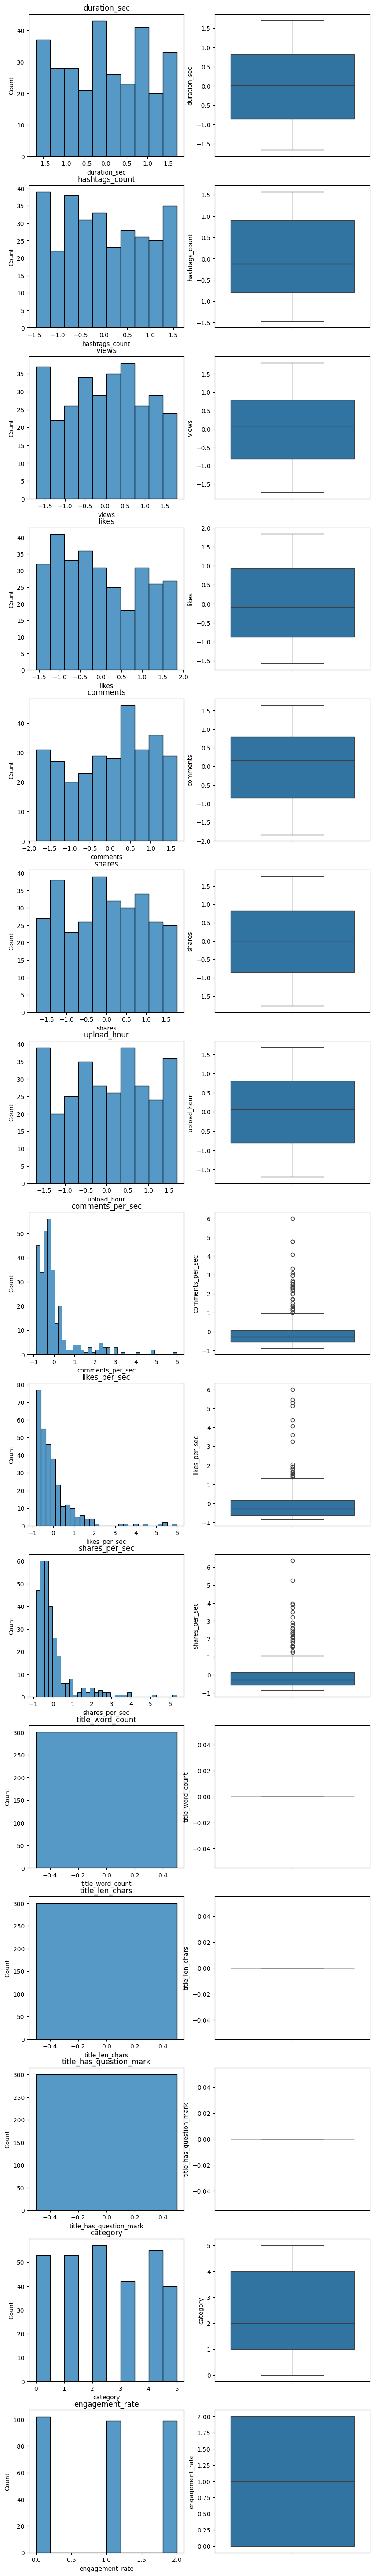

In [88]:
def univariant(df):
  import matplotlib.pyplot as plt
  fig , axes = plt.subplots(len(df.columns) , 2 , figsize = (10,len(df.columns)*5))
  print("Univeriant")
  for i  , col in enumerate(df.columns):
    sns.histplot(df[col] , ax = axes[i][0])
    axes[i][0].set_title(col)
    sns.boxplot(df[col] , ax = axes[i][1])


univariant(preprocess_result)

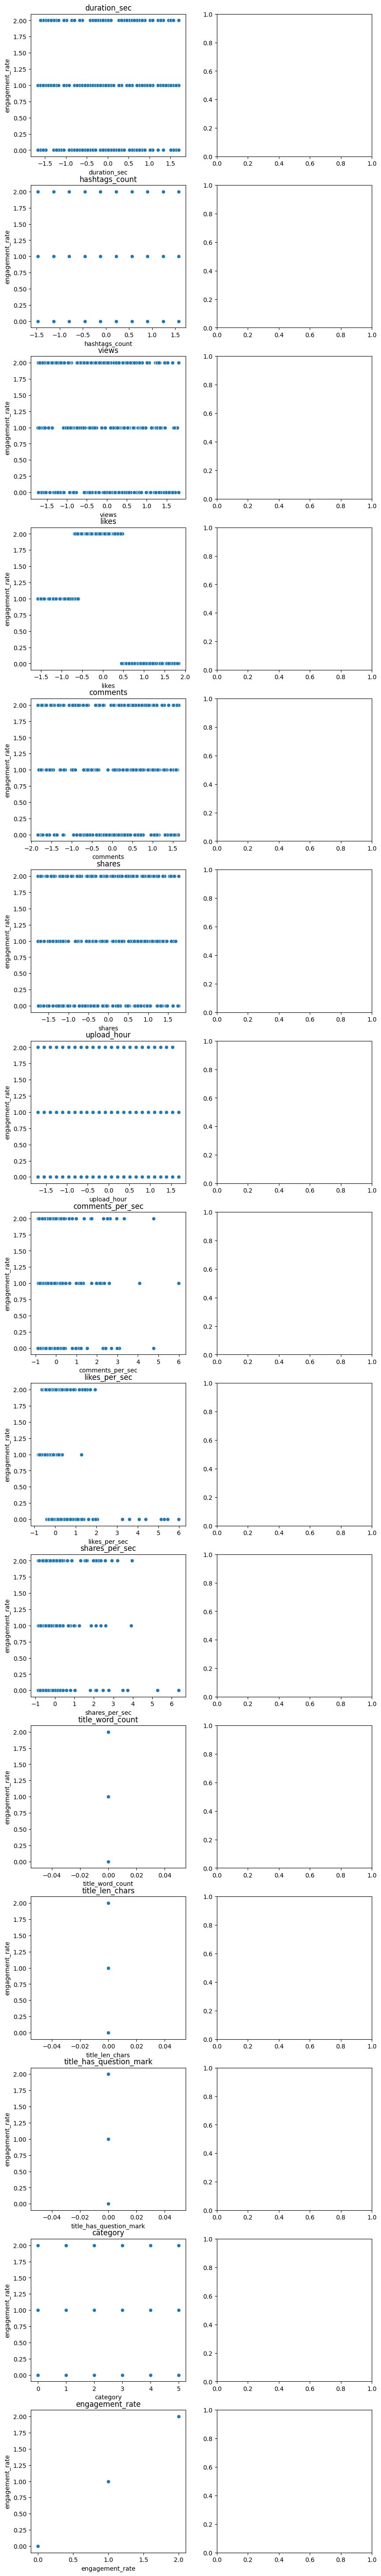

In [89]:
def bivariant(df):
  import matplotlib.pyplot as plt
  fig , axes = plt.subplots(len(df.columns) , 2, figsize = (10,len(df.columns)*5))
  y = df['engagement_rate']
  for i , col in enumerate(df.columns):
    sns.scatterplot(x = df[col], y =y , ax = axes[i][0])
    axes[i][0].set_title(col)
bivariant(preprocess_result)

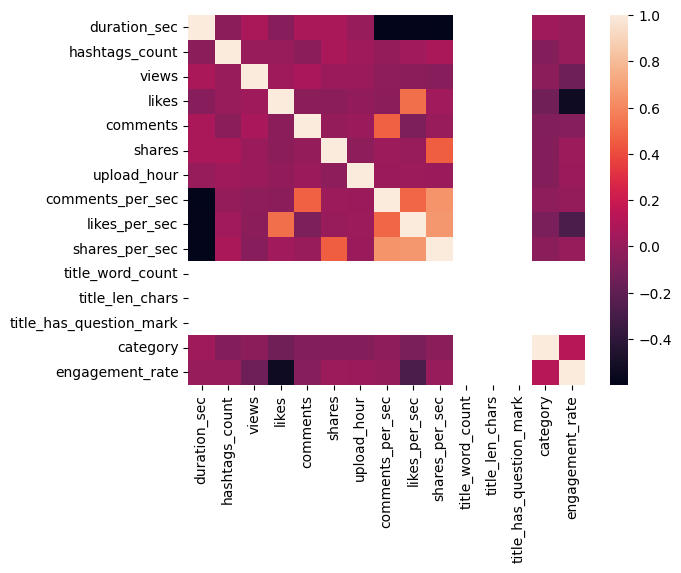

                      index  engagement_rate
14          engagement_rate         1.000000
13                 category         0.121688
5                    shares         0.021609
6               upload_hour         0.018337
9            shares_per_sec         0.006653
0              duration_sec         0.003354
1            hashtags_count         0.002801
7          comments_per_sec        -0.002332
4                  comments        -0.057937
2                     views        -0.147547
8             likes_per_sec        -0.282912
3                     likes        -0.540689
10         title_word_count              NaN
11          title_len_chars              NaN
12  title_has_question_mark              NaN


In [90]:
def corr(df):
  sns.heatmap(df.corr())
  plt.show()
  df_corr = df.corr()["engagement_rate"].reset_index()
  print(df_corr[df_corr["engagement_rate"] != np.nan].sort_values(by = "engagement_rate", ascending = False))
corr(preprocess_result)

In [91]:
def temp_df_creation(df):
  for col in df.columns:
    if col != "engagement_rate":
      df[col] = np.log1p(df[col])
  temp = df.copy()
  temp.head()
  for i in temp.columns:
    if i != "engagement_rate":
      temp.fillna(temp[i].mean(), inplace=True)
  for i in temp.columns:
    low = temp[i].quantile(0.33)
    high = temp[i].quantile(0.75)
    iqr = high - low
    low = low - (1.5 * iqr)
    high = high + (1.5 * iqr)
    temp[i] = np.where(temp[i] < low, low, temp[i])
  return temp

temp_df = temp_df_creation(preprocess_result)

def feature_select(data):

  from sklearn.ensemble import RandomForestClassifier
  from sklearn.model_selection import train_test_split

  df = data.drop("engagement_rate", axis=1)
  y = data["engagement_rate"]


  X_train, X_test , y_train, y_test = train_test_split(df,y, test_size=0.2, random_state=42)
  rf = RandomForestClassifier(n_estimators=100, random_state=42)
  rf.fit(X_train, y_train)

  cond = np.asarray(rf.feature_importances_)


  index = np.argwhere(cond > 0)
  index = index.reshape(1,-1)[0]
  features = X_train.columns[index]

  return features

features = feature_select(temp_df)

len(features)


/usr/local/lib/python3.12/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


11

In [92]:
def model_select( data , features):
    from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, roc_curve, roc_auc_score)
    X_lr = data.drop("engagement_rate", axis=1)
    y_lr = data["engagement_rate"]
    X_train, X_test , y_train, y_test = train_test_split(X_lr[features],y_lr, test_size=0.2, random_state=42)

    # Dictionary of models - Note the 'model__' prefix for GridSearchCV
    models = {
        "Logistic Regression": [LogisticRegression(class_weight='balanced', max_iter=50000),
                                {'model__C': np.logspace(-4, 4, 10)}],
        "Gaussian Naive Bayes": [GaussianNB(),
                                 {'model__var_smoothing': np.logspace(-9, -2, 50)}],
        "Decision Tree": [DecisionTreeClassifier(),
                          {'model__max_depth':  range(5, 100 , 10)}],
        "Random Forest": [RandomForestClassifier(),
                          {'model__n_estimators':  range(50, 500 , 50), 'model__max_depth': range(5, 100 , 10)}],
        "K-Nearest Neighbors": [KNeighborsClassifier(),
                                 {'model__n_neighbors': range(1, 100)}],
        "Support Vector Machine": [SVC(),
                                   {'model__C': np.logspace(-4, 4, 10), 'model__gamma': np.logspace(-4, 4, 10)}]
    }

    best_models = {}
    models_after_smote = {}

    for model_name in models:
        # Use your specific condition to select the dataset
        curr_X_train, curr_y_train = X_train, y_train
        curr_X_test, curr_y_test = X_test, y_test

        # Define the Pipeline: SMOTE is only applied to the training FOLD of CV
        # This prevents the 0.90 (CV) vs 0.50 (Test) discrepancy
        pipeline = Pipeline([

            ('model', models[model_name][0])
        ])

        param_grid = models[model_name][1]
        grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
        grid_search.fit(curr_X_train, curr_y_train)

        best_pipeline = grid_search.best_estimator_

        # Predictions
        predictions = best_pipeline.predict(curr_X_test)

        # Prepare y_score for roc_auc_score
        y_score_for_roc = None
        if hasattr(best_pipeline, "predict_proba") and best_pipeline.predict_proba is not None:
            y_score_for_roc = best_pipeline.predict_proba(curr_X_test)
        elif hasattr(best_pipeline, "decision_function") and best_pipeline.decision_function is not None:
            y_score_for_roc = best_pipeline.decision_function(curr_X_test)

        roc_auc_val = np.nan # Default value if ROC AUC cannot be calculated

        if y_score_for_roc is not None:
            try:
                roc_auc_val = roc_auc_score(curr_y_test, y_score_for_roc, multi_class='ovr', average='macro')

            except ValueError as e:
                print(f"Could not calculate ROC AUC for {model_name}: {e}")

        best_models[model_name] = {
            "model_name": model_name,
            "confusion": confusion_matrix(curr_y_test, predictions),
            "accuracy": accuracy_score(curr_y_test, predictions),
            "precision": precision_score(curr_y_test, predictions, average='macro'),
            "recall": recall_score(curr_y_test, predictions, average='macro'),
            "roc_auc" : roc_auc_val,
            "f1": f1_score(curr_y_test, predictions , average='macro')
        }

        models_after_smote[model_name] = {
            "model_name": model_name,
            "best_model": best_pipeline
        }

    return best_models, models_after_smote
best_models , models_after_smote = model_select(temp_df, features)

/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan

Could not calculate ROC AUC for Support Vector Machine: Target scores need to be probabilities for multiclass roc_auc, i.e. they should sum up to 1.0 over classes


/usr/local/lib/python3.12/dist-packages/sklearn/model_selection/_search.py:1108: UserWarning: One or more of the test scores are non-finite: [nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan nan
 nan nan nan nan nan nan nan nan nan nan]
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [93]:
best_models

{'Logistic Regression': {'model_name': 'Logistic Regression',
  'confusion': array([[19,  1,  0],
         [ 3, 14,  2],
         [ 9,  7,  5]]),
  'accuracy': 0.6333333333333333,
  'precision': 0.6545175254852674,
  'recall': 0.6416457811194652,
  'roc_auc': np.float64(0.8788703106787189),
  'f1': 0.5950559085422787},
 'Gaussian Naive Bayes': {'model_name': 'Gaussian Naive Bayes',
  'confusion': array([[18,  0,  2],
         [ 0, 13,  6],
         [ 0,  3, 18]]),
  'accuracy': 0.8166666666666667,
  'precision': 0.8349358974358975,
  'recall': 0.8137844611528822,
  'roc_auc': np.float64(0.9349517731947129),
  'f1': 0.8187276702394284},
 'Decision Tree': {'model_name': 'Decision Tree',
  'confusion': array([[20,  0,  0],
         [ 0, 17,  2],
         [ 1,  2, 18]]),
  'accuracy': 0.9166666666666666,
  'precision': 0.9157059314954051,
  'recall': 0.9172932330827068,
  'roc_auc': np.float64(0.9429530609408658),
  'f1': 0.9161317928968763},
 'Random Forest': {'model_name': 'Random Forest

In [94]:
def metrics_df(best_models):
  plot = []
  for i in best_models.keys():
    confusion__matrix = dict()
    confusion__matrix["model_name"] = i
    confusion__matrix["True Positive"] = best_models[i]["confusion"][0][0]
    confusion__matrix["False Positive"] = best_models[i]["confusion"][0][1]
    confusion__matrix["False Negative"] = best_models[i]["confusion"][1][0]
    confusion__matrix["True Negative"] = best_models[i]["confusion"][1][1]
    confusion__matrix["roc_auc"] = best_models[i]["roc_auc"]
    confusion__matrix["accuracy"] = best_models[i]["accuracy"]
    confusion__matrix["precision"] = best_models[i]["precision"]
    confusion__matrix["recall"] = best_models[i]["recall"]
    confusion__matrix["f1"] = best_models[i]["f1"]
    plot.append(confusion__matrix)

  plot_df = pd.DataFrame(plot)
  return plot_df
plot_df = metrics_df(best_models)
plot_df

,model_name,True Positive,False Positive,False Negative,True Negative,roc_auc,accuracy,precision,recall,f1
0,Logistic Regression,19,1,3,14,0.878870,0.633333,0.654518,0.641646,0.595056
1,Gaussian Naive Bayes,18,0,0,13,0.934952,0.816667,0.834936,0.813784,0.818728
2,Decision Tree,20,0,0,17,0.942953,0.916667,0.915706,0.917293,0.916132
3,Random Forest,20,0,0,11,0.974285,0.833333,0.857584,0.827903,0.825651
4,K-Nearest Neighbors,16,0,0,11,0.748689,0.666667,0.689206,0.665998,0.670791
5,Support Vector Machine,20,0,19,0,NaN,0.333333,0.111111,0.333333,0.166667


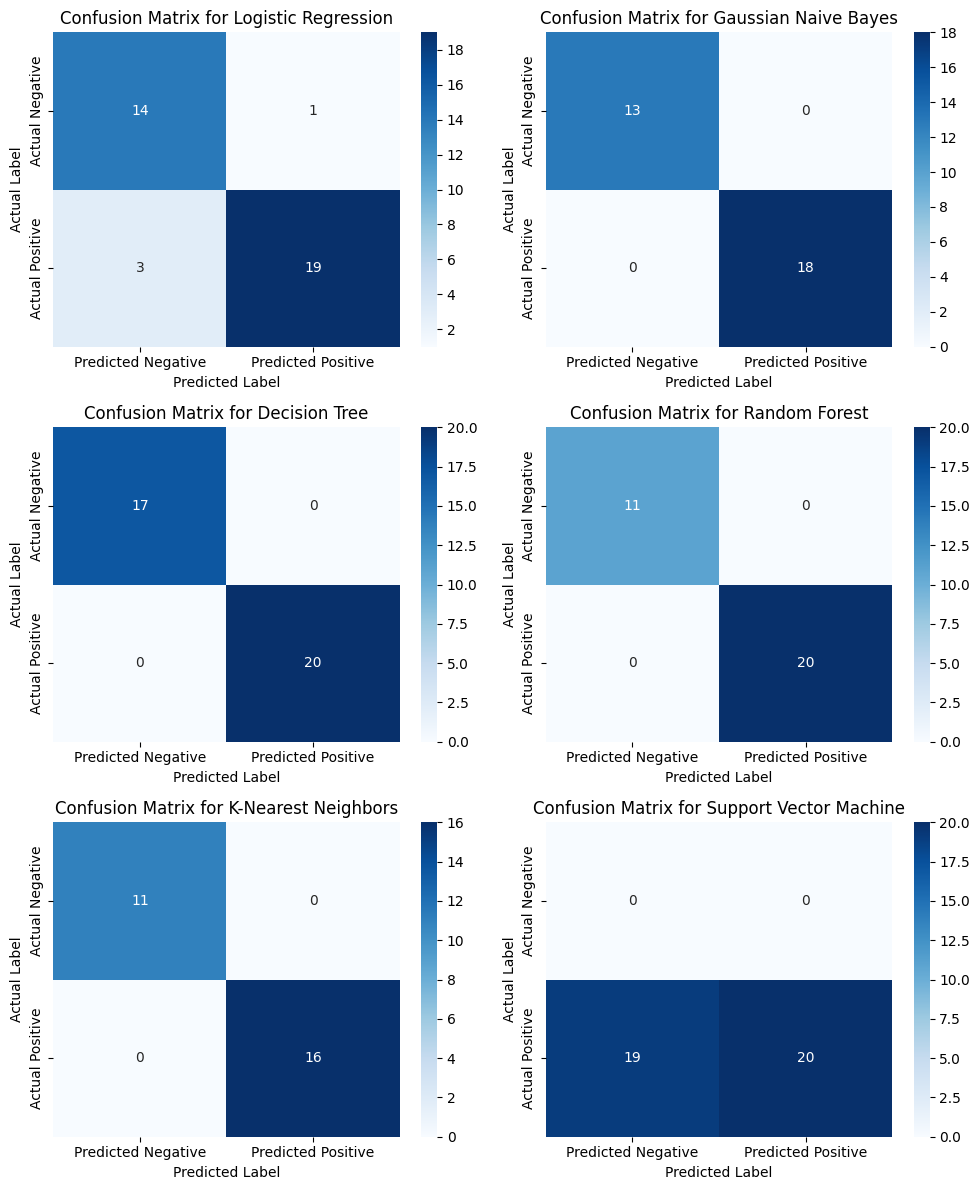

In [100]:
def plot_confusion_matrix(model_name, tp, fp, fn, tn, ax):

    # Create the 2x2 matrix
    cm = np.array([[tn, fp], [fn, tp]]) # TN in top-left, TP in bottom-right for standard layout

    # Create a DataFrame for the heatmap with desired labels
    cm_df = pd.DataFrame(cm,
                         index=['Actual Negative', 'Actual Positive'],
                         columns=['Predicted Negative', 'Predicted Positive'])

    sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues', ax=ax)
    ax.set_title(f'Confusion Matrix for {model_name}')
    ax.set_xlabel('Predicted Label')
    ax.set_ylabel('Actual Label')

# Calculate number of rows and columns for subplots
num_models = len(plot_df)
n_cols = 2# You can adjust this for desired number of columns
n_rows = (num_models + n_cols - 1) // n_cols # Ceiling division

fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4))
axes = axes.flatten() # Flatten the 2D array of axes for easy iteration

for i, (index, row) in enumerate(plot_df.iterrows()):
    plot_confusion_matrix(row['model_name'], row['True Positive'], row['False Positive'], row['False Negative'], row['True Negative'], ax=axes[i])

# Turn off any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()